# Regression modeling in R - a first pass

The following dataset containts measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`: the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook`: the advertising budget allocated to Facebook. Measured in thousands of dollars; and 

- `newspaper`: the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`: the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

In [1]:
library(RCurl) #a package that includes the function getURL(), which allows for reading data from github.
library(ggplot2)
url = getURL("https://raw.githubusercontent.com/bzaharatos/-Statistical-Modeling-for-Data-Science-Applications/master/Modern%20Regression%20Analysis%20/Datasets/marketing.txt")
marketing = read.csv(text = url, sep = "")
data(marketing)
head(marketing)

Loading required package: bitops
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message in data(marketing):
“data set ‘marketing’ not found”

youtube,facebook,newspaper,sales
276.12,45.36,83.04,26.52
53.40,47.16,54.12,12.48
20.64,55.08,83.16,11.16
181.80,49.56,70.20,22.20
216.96,12.96,70.08,15.48
10.44,58.68,90.00,8.64


## Exploratory data analysis

Before we model the data, let's first explore the data. We'll first check to see whether there are any missing values in the dataset. Then, we'll take a look at some univariate and bivariate summaries of the data.

*Note that, in an earlier lesson, we discussed the importance of randomly partitioning the data, and using one subset of the data for exploratory data analysis, another for fitting the model, and then possibly a third for model validation. However, for this dataset, there are only $n = 200$ units in the sample, and so there is not enough data for three robust subsets. So, we'll proceed to perform EDA on the entire dataset, but noting that our conclusions may be less certain because of the possibility of error due to "double dipping".*

### Missing data and univariate explorations

Are there any missing values coded as `NA`? Or, are there any odd values for variables, e.g., `9999` or `0` possibly standing in for a missing value? 

In [2]:
dim(marketing)
cat("There are", sum(is.na(marketing)), "missing data values.")
summary(marketing)

[1] 200   4

There are 0 missing data values.

    youtube          facebook       newspaper          sales      
 Min.   :  0.84   Min.   : 0.00   Min.   :  0.36   Min.   : 1.92  
 1st Qu.: 89.25   1st Qu.:11.97   1st Qu.: 15.30   1st Qu.:12.45  
 Median :179.70   Median :27.48   Median : 30.90   Median :15.48  
 Mean   :176.45   Mean   :27.92   Mean   : 36.66   Mean   :16.83  
 3rd Qu.:262.59   3rd Qu.:43.83   3rd Qu.: 54.12   3rd Qu.:20.88  
 Max.   :355.68   Max.   :59.52   Max.   :136.80   Max.   :32.40  


Attaching package: ‘tidyr’

The following object is masked from ‘package:RCurl’:

    complete



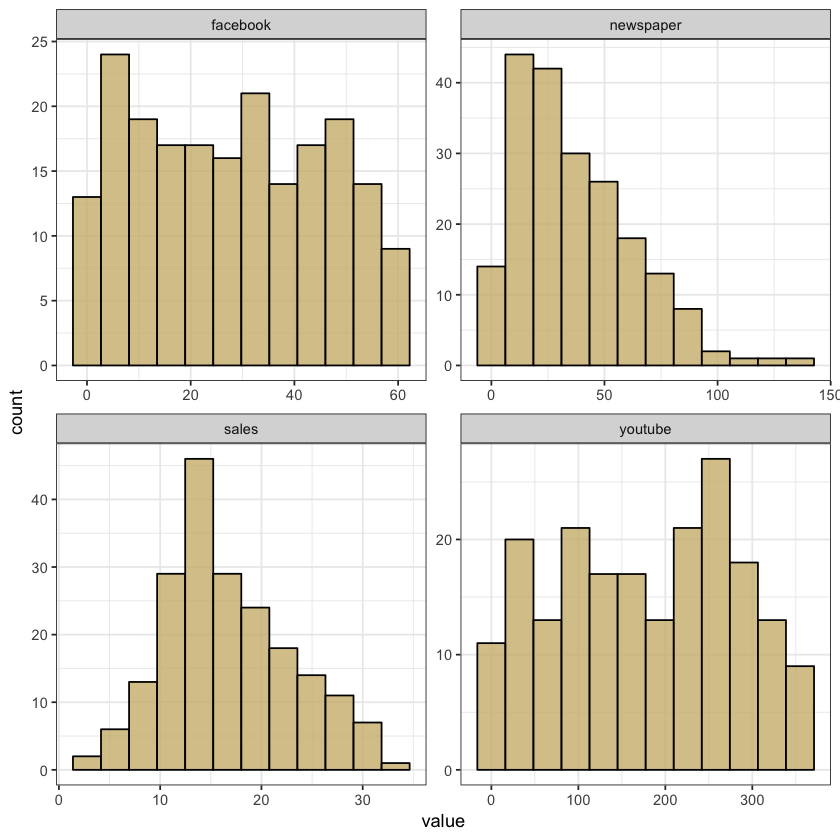

In [3]:
library(purrr)
library(tidyr)
library(ggplot2)

marketing %>%
  keep(is.numeric) %>% 
  gather() %>% 
  ggplot(aes(value)) +
    facet_wrap(~ key, scales = "free") +
    geom_histogram(bins = 12, color="black", fill ="#CFB87C", alpha = 0.8) + 
    theme_bw()

The histograms of each variable provide insight into the distributions of the variables. None look normal; however, there is no requirement that the predictors (`facebook`, `youtube`, `newspaper`) come from a normal distribution. The response, `sales` does not look all that normal, but as we'll see, some regression analyses can be fairly robust to deviations in the normality assumption.

We can see from the histogram of `newspaper` that there may be a few outliers. Let's look at some boxplots to see in further detail. Note that 

R classifies potential outliers by the "IQR criterion". This criterion means that all observations above $q_{0.75}+1.5\times IQR$ or below $q_{0.25}-1.5\times IQR$ are classified as outliers, where 

- $q_{0.25}$ is the first quartile;
- $q_{0.75}$ is the third quartile. 
- IQR is the interquartile range, defined as the difference between the third and first quartile. 

A boxplot wil "flag" the outliers:

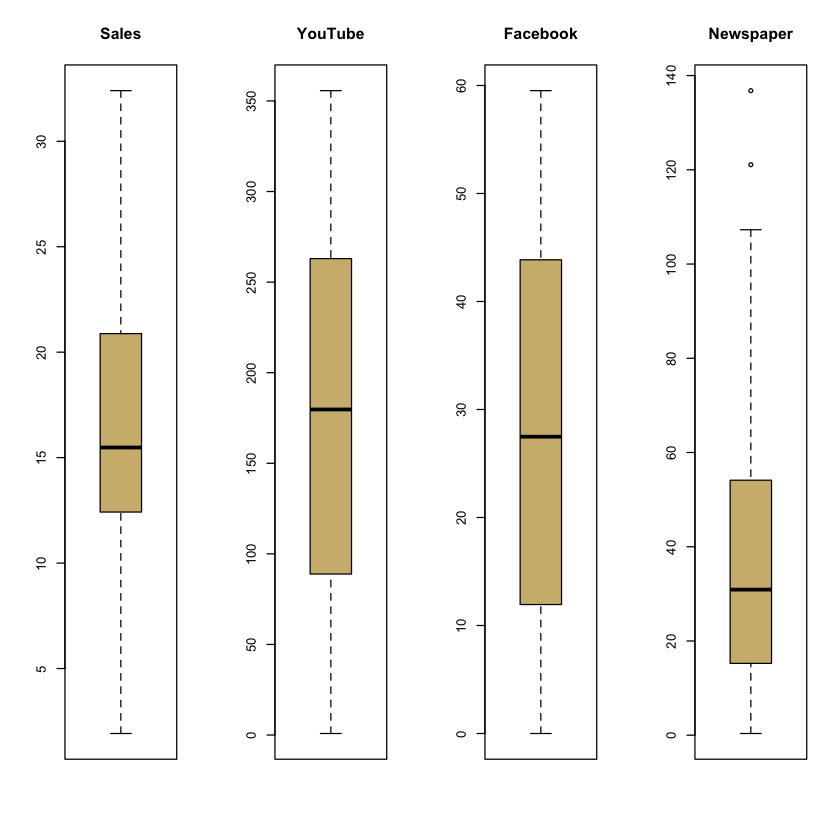

In [4]:
par(mfrow = c(1, 4))
boxplot(marketing$sales, main='Sales',col="#CFB87C")
boxplot(marketing$youtube, main='YouTube',col="#CFB87C")
boxplot(marketing$facebook, main='Facebook',col="#CFB87C")
boxplot(marketing$newspaper, main='Newspaper',col="#CFB87C")

In [5]:
cat("The outliers for the Newspaper variable are ", boxplot.stats(marketing$newspaper)$out[1],
    " and ",boxplot.stats(marketing$newspaper)$out[2], "." )

The outliers for the Newspaper variable are  136.8  and  121.08 .

Using the interquartile range criterion, we see that `newspaper` has two potential outliers. We simply note this for now, and note that outliers can impact the fit of a regression.

### Bivariate explorations
Let's now explore how the variables may or may not relate to each other. First, calculate the correlations between variables. Correlations can help us meaasure the strength of the linear relationship between variables. We'll do this with the `corrplot()` function.

corrplot 0.84 loaded


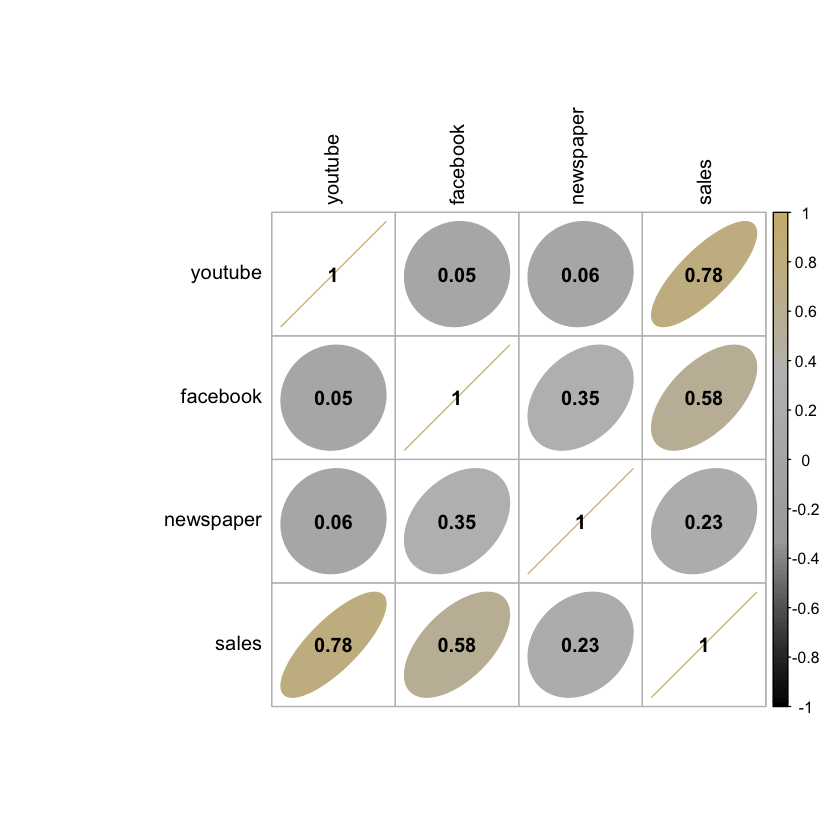

In [6]:
library(corrplot)
col4 <- colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(marketing), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

Note that there's a relatively strong correlation between `sales` and `youtube`, and `sales` and `facebook`. However, knowing correlations alone isn't enough; the correlation coefficient can be misleading if there are nonlinear relationships, and so we should explore the relationships further.

To do so, we'll look at pairwise scatter plots, i.e., a scatter plot of each variable with each other variable. We should be looking for:

- Relationships between the response and each predictor. 
- Relationships between predictor variables. Such relationships are undesirable. 

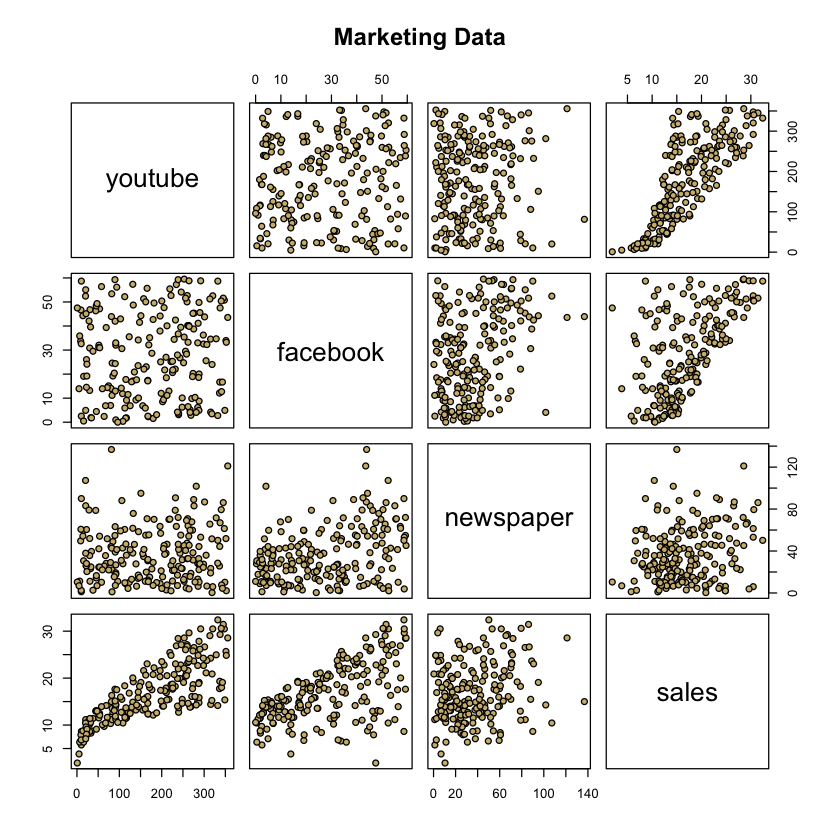

In [7]:
pairs(marketing, main = "Marketing Data", pch = 21, 
      bg = c("#CFB87C"))

Here are some notes on the relationships:

- The relationship between `sales` and `youtube` appears nonlinear, with a sharp increase in sales for a small increase in YouTube advertising in the lower range of `youtube`. As more money is spent on YouTube advertising, however, the increase in sales is less prevalent.

- It's also worth noting that, as `youtube` increases, the variability in sales also increases.

- There appears to be a linear relationship between `sales` and `facebook`, too, but with a lot of variability, especially for high vales of `facebook` and low `sales`.

- There doesn't appear to be a relationship between `sales` and `newspaper`.

- There aren't any other strong trends in the data.


## Linear regression modeling

First, let's randomly split the data into a "training set" and "testing set". We do this so that we can train/fit the linear model on the training set, and then, if necessary, see how well the model fits (e.g., does it make reasonable predictions?) in the testing set. In this lesson, we will only briefly look at fit metrics on the testing set; but, it's good practice to split the data in this (or a similar) way when wanting to assess the fit or predictive power of the model.

In [8]:
set.seed(11) #set the random number generator seed.
n = floor(0.8 * nrow(marketing)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(marketing)), size = n) #randomly sample indicies to be included in the training set

train = marketing[index, ] #set the training set to be the randomly sampled rows of the dataframe
test = marketing[-index, ] #set the testing set to be the remaining rows
cat("There are", dim(train)[1], "rows and",dim(train)[2],"columns in the training set. ")  #check the dimensions
cat("There are", dim(test)[1], "rows and",dim(test)[2],"columns in the testing set.")  #check the dimensions

There are 160 rows and 4 columns in the training set. There are 40 rows and 4 columns in the testing set.

### The `lm()` function

`R` has a great function for fitting and summarizing linear regression models: the `lm()` function. `lm()` will fit a linear regression model to data using least squares (or other methods, when specified), and provide many summary statistics. Let's look at some basics of `lm()`. As we progress through the course, we'll learn to work with more and more of the output of the `lm()` function.

The `lm()` function may take in several arguments, but only a small number of them are required. The first required argument is the `formula`: it should be in the following format: `response ~ predictor1 + predictor2 + ... + predictorP`. If your data are stored in a dataframe (which will often be the case), then the simplest thing to do is specify a second argument, namely `data = NameOfDataFrame`. Let's use `lm()` on the training subset of the marketing data, first for just the `facebook` predictor.

In [9]:
lm_marketing = lm(sales ~ facebook, data = train)
summary(lm_marketing)


Call:
lm(formula = sales ~ facebook, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.573  -2.535   1.069   3.422  10.160 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 11.32793    0.82030  13.810  < 2e-16 ***
facebook     0.19287    0.02396   8.049 1.88e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.387 on 158 degrees of freedom
Multiple R-squared:  0.2908,	Adjusted R-squared:  0.2863 
F-statistic: 64.79 on 1 and 158 DF,  p-value: 1.881e-13


The `summary()` function applied to an `lm()` object gives is plenty of output:

- First, the summary function reminds us of the formula for the model, i.e., that `sales` is the response and `facebook` the predictor. 

- Next, we have summary statistics for the residuals of the model. Recall that the residuals are defined as $\varepsilon_i = y_i - \widehat{y_i}$, where $\widehat{y_i} = \widehat\beta_0 + \widehat\beta_1facebook_i, \,\, i = 1,...,n$ are the fitted values of the model. If the model fits well, the residuals will look *roughly* normal/random scatter around zero.

- Next, we see a table of, among other things, the least squares estimates for the model. In the last module, we learned how to interpret these estimates:
    - If the model is correct, then if a company spend zero dollars on Facebook advertising, they can expect to sell roughly $\widehat\beta_0 \times 1000 = 11.33 \times 1,000 = 11,330$ units, on average.
    
    - If the model is correct, then, for a $\$1,000$ increase in the Facebook advertising budget, the company can expect to sell roughly $\widehat\beta_1 \times 1000 = 0.19 \times 1,000 = 190$ more units, on average.
    

- We'll ignore the remaining components of the coefficient table for now, but will return to them soon!

- We'll also ignore the residual standard error, $R^2$, and F-statistic information. We'll return to this when we discuss regression inference.



#### Computing regression quantities "by hand"

Let's connect the `lm()` function output to the computations that we learned about in class. First, let's construct the "design matrix", $X$, i.e., the matrix with a column of `1's`, and then columns for each predictor.

In [10]:
X = cbind(1, train$facebook) 

#another way to do this:
#X1 = model.matrix(lm_marketing)
#sum(X-X1)

Recall that the least squares solution is: $\boldsymbol{\widehat\beta} = \left(X^TX \right)^{-1}X^T\mathbf{y}$. To compute this "by hand" in `R`, we'll need the transpose function, `t()`, the operator for matrix multiplication, `%*%`, and the function for finding the inverse of a matrix, `solve()`. 

Imoprtantly, this is *not* how `R` (or other software packates, like `Python`) actually computes the least squares estimates. Instead, they use methods that are less computationally expensive. We are computing the least squares estimates in this way to show that the theory from class matches the values from `R`. The theory will be important for our understanding and interpretation of linear regression.

In [11]:
y = train$sales
b = solve(t(X)%*%X)%*%t(X)%*%y
b

11.3279292
0.1928711


Let's now compute the fitted values and residuals of the model:

In [12]:
yhat = X%*%b 

#note that these are the same as the fitted values from the lm() function:
sum(yhat - fitted(lm_marketing)) #machine zero

r = y - yhat

#note that these are the same as the residuals from the lm() function:
sum(r - residuals(lm_marketing)) #machine zero


[1] 2.007283e-13

[1] -2.059498e-13

## Visualizing the regression model

We will learn a few important visualizations of the linear regression model in the modules to come. For now, let's just visualize our data with the regression model imposed on it.


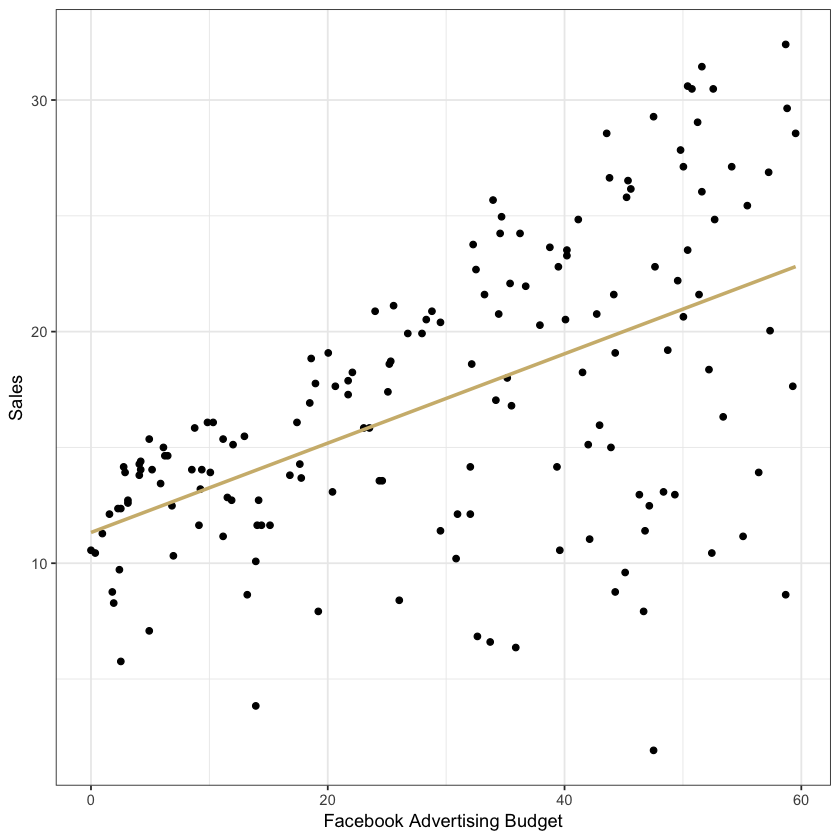

In [13]:
ggplot(train, aes(x = facebook, y = sales)) + 
    geom_point() + 
    geom_smooth(method = "lm", col = "#CFB87C", se = F) + 
    theme_bw() + 
    xlab("Facebook Advertising Budget") + 
    ylab("Sales")

We note that the fit looks OK, but that there is a lot of variability in `sales`, especially for higher values of `facebook`. Imagine making a prediction for `sales` for `facebook = 60`:

In [14]:
yhat_60 = as.numeric(round(coef(lm_marketing)[1] + coef(lm_marketing)[2]*60, 2))

The model predicts `sales = 22.9`: that is, the model predicts that a company with a facebook marketing budget of $\$60,000$ will sell $22,900$ units of product $P$, on average. But look at other measurements near $\$60,000$; based on the data, sales could be as low as $9,000$ units or over $30,000$ units.

Finally, let's take a look at how the plot would look using the testing data instead of the training data. Ideally, we would want the the model to fit well for the testing data too. Note that overlaying the regression line on a scatterplot of the data is not a rigorous way of assessing the fit of the model; later on in the course, we will learn better goodness of fit metrics for linear regression.

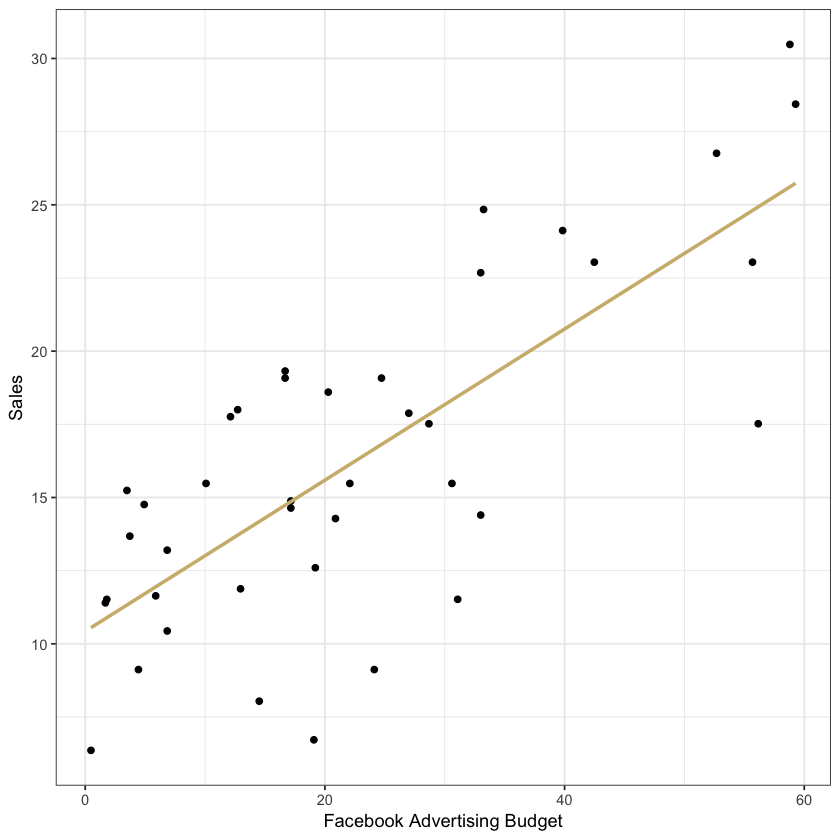

In [15]:
ggplot(test, aes(x = facebook, y = sales)) + 
    geom_point() + 
    geom_smooth(method = "lm", col = "#CFB87C", se = F) + 
    theme_bw() + 
    xlab("Facebook Advertising Budget") + 
    ylab("Sales")